In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [3]:
from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.preprocessing import  OrdinalEncoder, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# Load and split the data

In [4]:
train_csv = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
X = train_csv.drop(columns = ['Crime_Category'])
y = train_csv['Crime_Category']

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

x_train, x_validation, y_train , y_validation = train_test_split(X, label_encoded_y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_validation.shape, y_validation.shape

((16000, 21), (16000,), (4000, 21), (4000,))

In [5]:
x_train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
5894,CAMULOS,8TH,34.0257,-118.2139,01/06/2020 12:00:00 AM,01/05/2020 12:00:00 AM,2355.0,4.0,Hollenbeck,487.0,...,0337 0334 0344,25.0,M,H,101.0,STREET,102.0,HAND GUN,IC,Invest Cont
3728,500 GALLARDO ST,NaN,34.0588,-118.2221,11/11/2020 12:00:00 AM,11/11/2020 12:00:00 AM,1230.0,4.0,Hollenbeck,441.0,...,0444 0913,29.0,M,O,104.0,DRIVEWAY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
8958,00 20TH AV,NaN,33.9850,-118.4714,10/02/2020 12:00:00 AM,10/02/2020 12:00:00 AM,1425.0,14.0,Pacific,1431.0,...,0344 1606,24.0,M,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
7671,700 N EL CENTRO AV,NaN,34.0835,-118.3245,05/05/2020 12:00:00 AM,04/03/2020 12:00:00 AM,1300.0,6.0,Hollywood,676.0,...,1822 0344 0329 1300,50.0,F,W,707.0,GARAGE/CARPORT,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont
5999,8000 VINELAND AV,NaN,34.2157,-118.3703,04/06/2020 12:00:00 AM,04/04/2020 12:00:00 AM,1725.0,16.0,Foothill,1687.0,...,0344,31.0,F,W,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont


In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 5894 to 15795
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               16000 non-null  object 
 1   Cross_Street           2741 non-null   object 
 2   Latitude               16000 non-null  float64
 3   Longitude              16000 non-null  float64
 4   Date_Reported          16000 non-null  object 
 5   Date_Occurred          16000 non-null  object 
 6   Time_Occurred          16000 non-null  float64
 7   Area_ID                16000 non-null  float64
 8   Area_Name              16000 non-null  object 
 9   Reporting_District_no  16000 non-null  float64
 10  Part 1-2               16000 non-null  float64
 11  Modus_Operandi         13770 non-null  object 
 12  Victim_Age             16000 non-null  float64
 13  Victim_Sex             13865 non-null  object 
 14  Victim_Descent         13865 non-null  object 
 15  Prem

In [7]:
x_train.nunique()

Location                 10595
Cross_Street              1290
Latitude                  3413
Longitude                 3391
Date_Reported              763
Date_Occurred              366
Time_Occurred              905
Area_ID                     21
Area_Name                   21
Reporting_District_no     1114
Part 1-2                     2
Modus_Operandi            8523
Victim_Age                 100
Victim_Sex                   4
Victim_Descent              17
Premise_Code               205
Premise_Description        204
Weapon_Used_Code            55
Weapon_Description          55
Status                       5
Status_Description           5
dtype: int64

In [8]:
x_train.describe(include = ['object', 'number'])

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
count,16000,2741,16000.000000,16000.000000,16000,16000,16000.000000,16000.000000,16000,16000.000000,...,13770,16000.000000,13865,13865,16000.000000,15996,5832.000000,5832,16000,16000
unique,10595,1290,NaN,NaN,763,366,NaN,NaN,21,NaN,...,8523,NaN,4,17,NaN,204,NaN,55,5,5
top,6TH ST,BROADWAY,NaN,NaN,06/16/2020 12:00:00 AM,01/01/2020 12:00:00 AM,NaN,NaN,77th Street,NaN,...,0344,NaN,M,H,NaN,STREET,NaN,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
freq,29,45,NaN,NaN,72,113,NaN,NaN,1090,NaN,...,645,NaN,6838,4901,NaN,4052,NaN,3175,12242,12242
mean,NaN,NaN,33.939696,-117.888941,NaN,NaN,1352.231625,10.847125,NaN,1130.833250,...,NaN,30.057625,NaN,NaN,297.447000,NaN,366.415295,NaN,NaN,NaN
std,NaN,NaN,2.136978,7.413031,NaN,NaN,646.933662,6.028860,NaN,602.929145,...,NaN,21.933168,NaN,NaN,212.282136,NaN,120.671134,NaN,NaN,NaN
min,NaN,NaN,0.000000,-118.663400,NaN,NaN,1.000000,1.000000,NaN,101.000000,...,NaN,-2.000000,NaN,NaN,101.000000,NaN,101.000000,NaN,NaN,NaN
25%,NaN,NaN,34.009100,-118.431200,NaN,NaN,930.000000,6.000000,NaN,632.000000,...,NaN,10.000000,NaN,NaN,101.000000,NaN,312.000000,NaN,NaN,NaN
50%,NaN,NaN,34.058800,-118.323100,NaN,NaN,1430.000000,11.000000,NaN,1162.000000,...,NaN,31.000000,NaN,NaN,203.000000,NaN,400.000000,NaN,NaN,NaN
75%,NaN,NaN,34.166400,-118.274900,NaN,NaN,1900.000000,16.000000,NaN,1623.000000,...,NaN,46.000000,NaN,NaN,501.000000,NaN,400.000000,NaN,NaN,NaN


# Missing values

In [9]:
x_train.isna().sum()
#(x_train.isin(['NA', 'N/A', '-'])).sum()

Location                     0
Cross_Street             13259
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2230
Victim_Age                   0
Victim_Sex                2135
Victim_Descent            2135
Premise_Code                 0
Premise_Description          4
Weapon_Used_Code         10168
Weapon_Description       10168
Status                       0
Status_Description           0
dtype: int64

In [10]:
x_train.isna().sum()/x_train.shape[0]

Location                 0.000000
Cross_Street             0.828688
Latitude                 0.000000
Longitude                0.000000
Date_Reported            0.000000
Date_Occurred            0.000000
Time_Occurred            0.000000
Area_ID                  0.000000
Area_Name                0.000000
Reporting_District_no    0.000000
Part 1-2                 0.000000
Modus_Operandi           0.139375
Victim_Age               0.000000
Victim_Sex               0.133437
Victim_Descent           0.133437
Premise_Code             0.000000
Premise_Description      0.000250
Weapon_Used_Code         0.635500
Weapon_Description       0.635500
Status                   0.000000
Status_Description       0.000000
dtype: float64

Looking at the proportion of nans in the Cross_Street & Weapon_Used columns - it would be better to remove them.
Will try imputing other columns with an imputer that makes sense to that column

# Let's explore numeric attributes

In [11]:
x_train.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,5832.000000
mean,33.939696,-117.888941,1352.231625,10.847125,1130.833250,1.418688,30.057625,297.447000,366.415295
std,2.136978,7.413031,646.933662,6.028860,602.929145,0.493359,21.933168,212.282136,120.671134
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009100,-118.431200,930.000000,6.000000,632.000000,1.000000,10.000000,101.000000,312.000000
50%,34.058800,-118.323100,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.166400,-118.274900,1900.000000,16.000000,1623.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,966.000000,515.000000


array([[<Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Time_Occurred'}>],
       [<Axes: title={'center': 'Area_ID'}>,
        <Axes: title={'center': 'Reporting_District_no'}>,
        <Axes: title={'center': 'Part 1-2'}>],
       [<Axes: title={'center': 'Victim_Age'}>,
        <Axes: title={'center': 'Premise_Code'}>,
        <Axes: title={'center': 'Weapon_Used_Code'}>]], dtype=object)

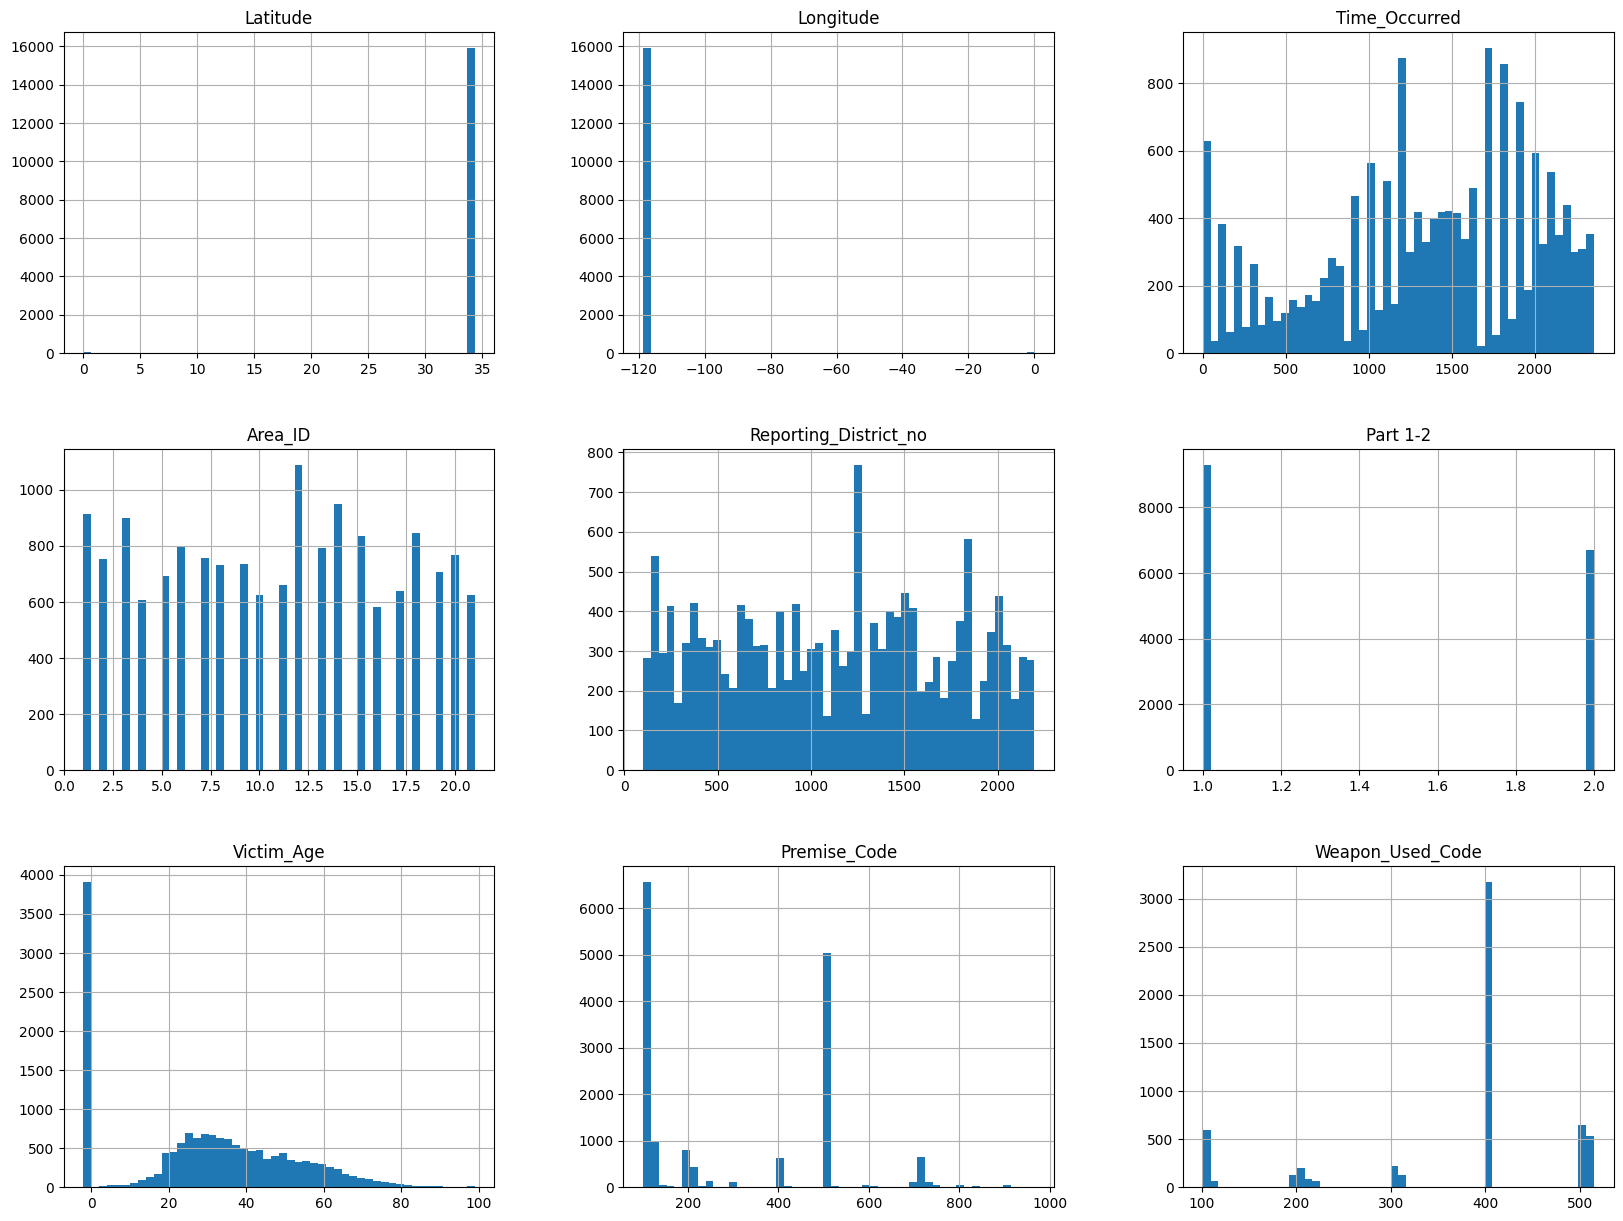

In [12]:
x_train.hist(bins=50, figsize=(20, 15))

# Age
Minimum value of age is below 0 which must be invalid

In [13]:
x_train[x_train['Victim_Age'] <= 0].shape

(3912, 21)

<Axes: ylabel='Density'>

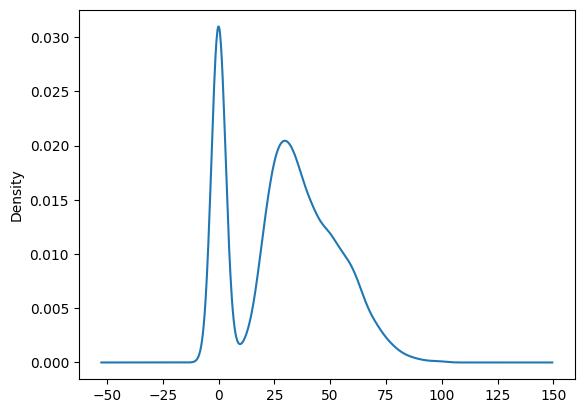

In [14]:
x_train['Victim_Age'].plot(kind='density')

Density plot suggests that zero age is invalid. Let's transorm and impute the column

In [15]:
def replace_zero_or_negative(X):
    return np.where(X <= 0, np.nan, X)

invalid_age_transformer = FunctionTransformer(replace_zero_or_negative, validate=True)
age_pipeline = Pipeline(steps=[
    ('invalid_age_transformer', invalid_age_transformer),
    ('smpl_imputer', SimpleImputer(strategy='mean')),
    ('min_max_scaler', MinMaxScaler())
])

# Latitude and Longitude
One idea is to bin the lat & long and then one hot encode it, But since we already have Reporting_District_no & Area_ID which can be similar let's not use this column in model to start with considering the columns it can add and complexity

# Time_Occurred

<Axes: >

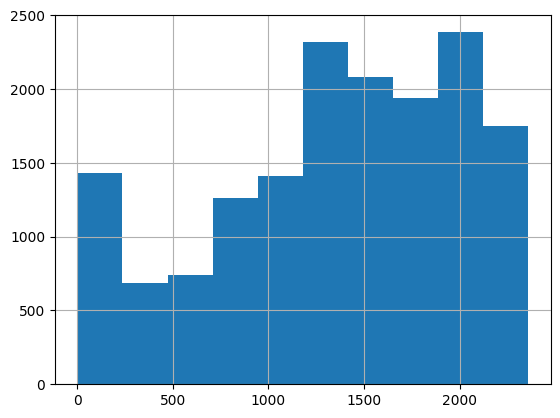

In [16]:
x_train['Time_Occurred'].hist()

Let us bin Occured time into 5 bins -
 

* 3 AM - 8 AM : 1
* 8 AM - 12 PM : 2
* 12 PM - 4 PM : 3
* 4 PM - 7 PM : 4
* 7 PM - 3 AM : 5

And then OneHot Encode

In [17]:
def bin_military_time(t):
    if (t > 300) & (t <= 800):
        return 1
    elif (t > 800) & (t <= 1300):
        return 2
    elif (t > 1300) & (t <= 1800):
        return 3
    elif (t > 1800) & (t <= 2200):
        return 4
    else:
        return 5

def make_bins(X):
  time_of_occurrence = X[:, 0]
  l = []
  for t in time_of_occurrence:
    l.append(bin_military_time(t))
  return np.array(l).reshape(-1, 1)

military_time_transformer = FunctionTransformer(make_bins, validate=True)
military_time_pipeline = Pipeline(steps=[
    ('military_time_transformer', military_time_transformer),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Exploring numeric attributes that have categorical behavior

# Area_ID


<Axes: xlabel='Area_ID'>

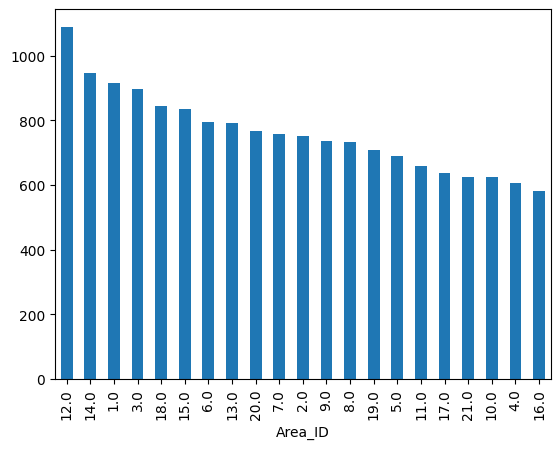

In [18]:
x_train['Area_ID'].value_counts().plot.bar()

Since this is a geographical area ID, we need to OneHot encode it - Also we will not be considering Area_Name as they both have the same information as far as model is concerned

# Reporting_District_no

<Axes: xlabel='Reporting_District_no'>

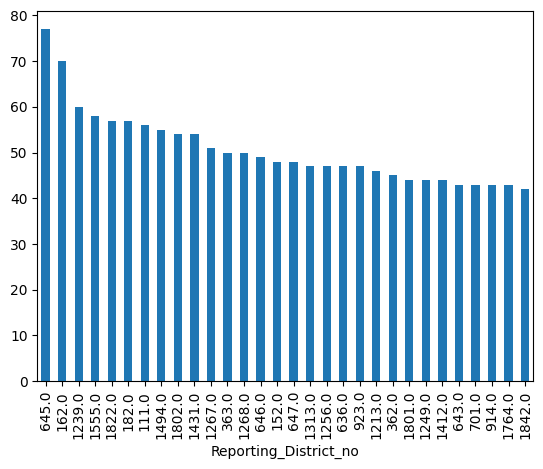

In [19]:
x_train['Reporting_District_no'].value_counts().head(30).plot.bar()

Since this is also a geographical area representation, let's OneHot encode it

# Part 1-2

<Axes: xlabel='Part 1-2'>

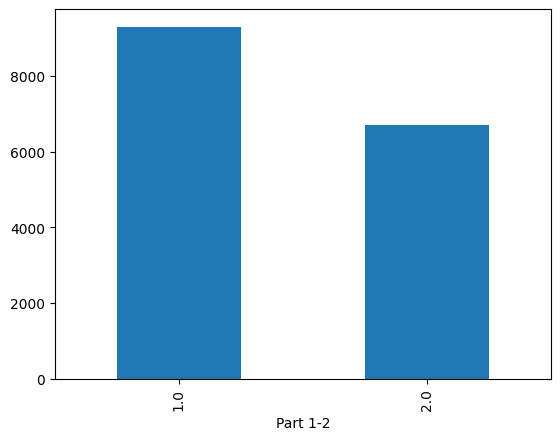

In [20]:
x_train['Part 1-2'].value_counts().plot(kind='bar')

Here part 1 is for severe crimes, so a transformation is made such that part 1 has a higher score of 5

In [21]:
def replace_one_with_five(X):
    return np.where(X == 1, 5, X)

part_reorder_transformer = FunctionTransformer(replace_one_with_five, validate=True)
part_pipeline = Pipeline(steps=[
    ('part_reorder_transformer', part_reorder_transformer),
    ('min_max_scaler', MinMaxScaler())
])

# Premise_Code / Premise_Description


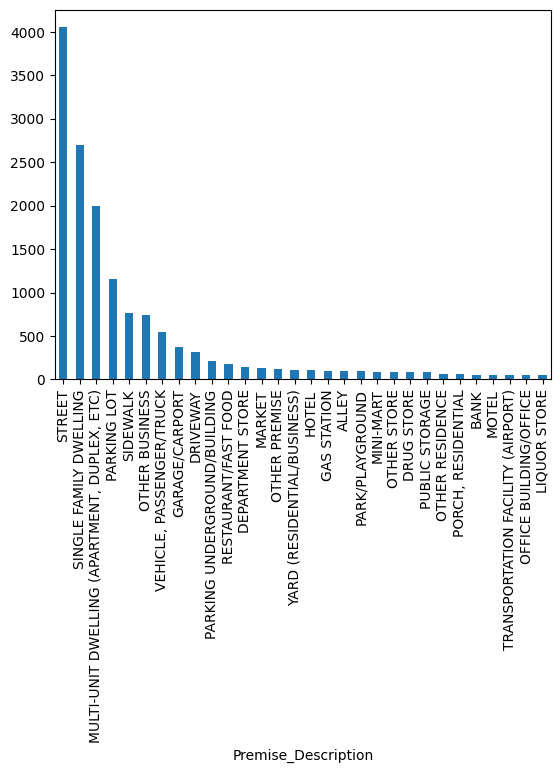

In [22]:
top_premises = x_train['Premise_Description'].value_counts().head(30).plot.bar()

The data represented here is categorical and is almost simalr to Premise_Code We can OneHot encode one of these columns and discard other

# Weapon_Used_Code

<Axes: xlabel='Weapon_Description'>

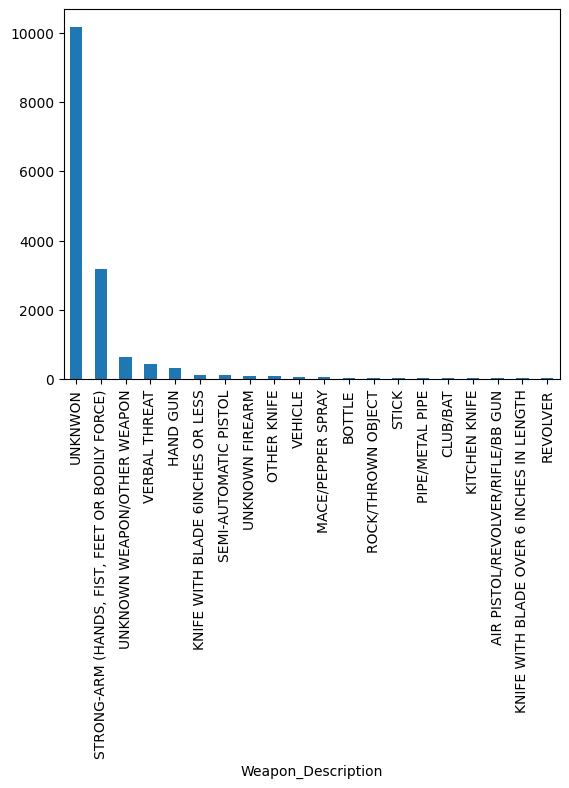

In [23]:
x_train['Weapon_Description'].fillna('UNKNWON').value_counts().head(20).plot.bar()

As we observed from the missing values analysis, this feature is mostly unknown data - making it not very usefull. 
But I strongly believe weapon used could be of help in someway (may be combining with any other feature and then OneHot encoding).
For now I will go with discarding this column

# **Categoric Features**

# Status

<Axes: xlabel='Status'>

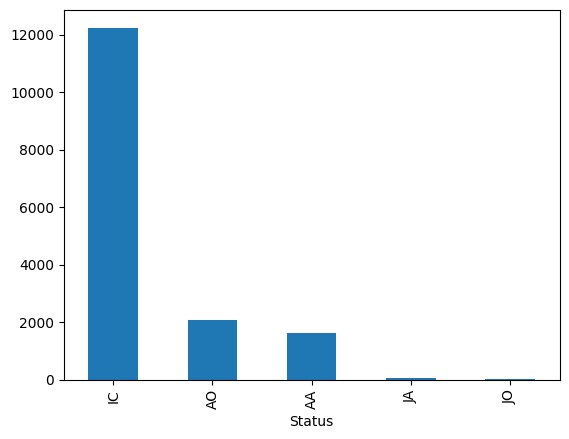

In [24]:
x_train['Status'].value_counts().plot(kind='bar')

<Axes: xlabel='Status_Description'>

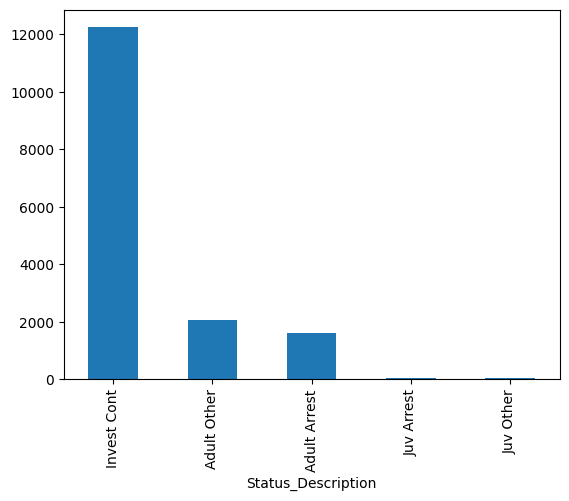

In [25]:
x_train['Status_Description'].value_counts().plot(kind='bar')

Most samples are in the status of investigation continued. 
Status & Status_Description represents the same thing and we can OneHot encode it for now (May be later if we can find there is an order for the status we can comeback and change it)

# Victim_Sex

<Axes: xlabel='Victim_Sex'>

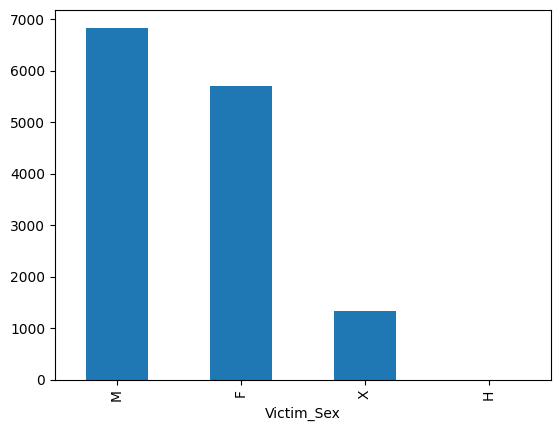

In [26]:
x_train['Victim_Sex'].value_counts().plot(kind='bar')

# Victim_Descent

<Axes: xlabel='Victim_Descent'>

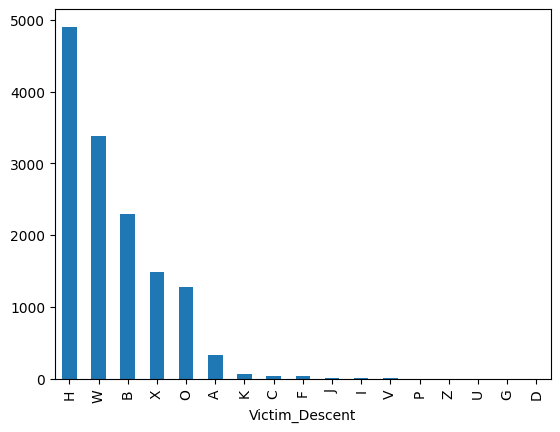

In [27]:
x_train['Victim_Descent'].value_counts().plot(kind='bar')

#  Location


<Axes: xlabel='Location'>

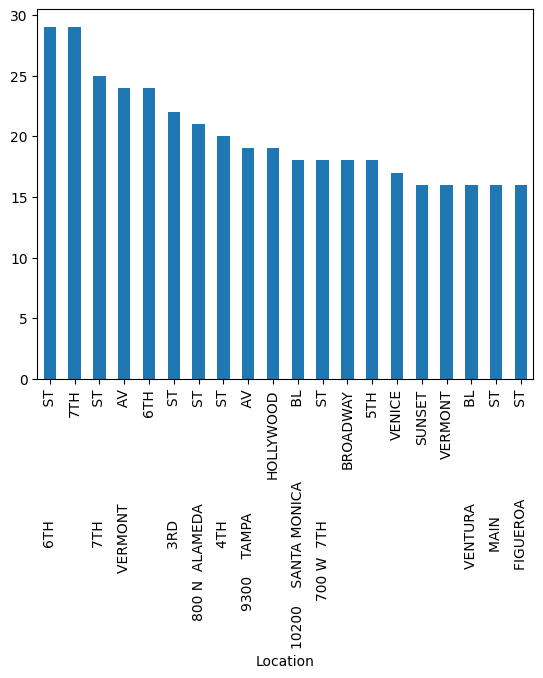

In [28]:
x_train['Location'].value_counts().head(20).plot(kind='bar')

# Cross_Street


<Axes: xlabel='Cross_Street'>

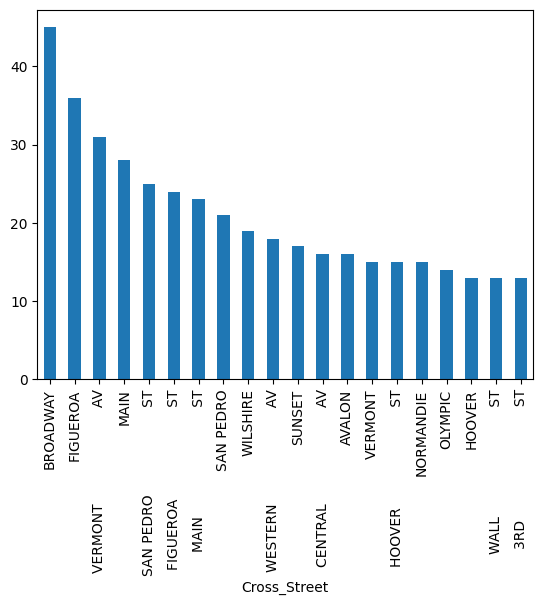

In [29]:
x_train['Cross_Street'].value_counts().head(20).plot(kind='bar')

# Date_Occurred, Date_Reported

In [30]:
def split_date(X):
    X_transformed = X.copy()
    date_occurred = pd.to_datetime(X_transformed['Date_Occurred'], format='%m/%d/%Y %H:%M:%S %p', errors='coerce')
    X_transformed['Year_occurred'] = date_occurred.dt.year
    X_transformed['Month_occurred'] = date_occurred.dt.month
    X_transformed['Day_of_month_occurred'] = date_occurred.dt.day 
    X_transformed['Day_of_week_occurred'] = date_occurred.dt.dayofweek
    X_transformed.drop(columns=['Date_Occurred'], inplace=True)
    return X_transformed
    

date_occurred_transformer = FunctionTransformer(split_date)
date_occurred_pipeline = Pipeline(steps=[
    ('date_occurred_transformer', date_occurred_transformer),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# this is the transformer that runs after date_delay_transformer is run
# in the output of date_delay_transformer there are 2 columns
# Date_Occurred - at index 0 and 
# Delay_time - at index 1
date_column_aggr_transformer = ColumnTransformer(
    transformers=[
        ('date_pipeline', date_occurred_pipeline, [0]),
        ('min_max_scaler', MinMaxScaler(), [1])
    ]
)

def convert_to_delay(X):
    X_t = X.copy()
    delay = pd.to_datetime(X_t['Date_Reported'], format='%m/%d/%Y %H:%M:%S %p', errors='coerce').values.astype(int) - pd.to_datetime(X_t['Date_Occurred'], format='%m/%d/%Y %H:%M:%S %p', errors='coerce').values.astype(int)
    X_t['Delay_time'] = delay
    X_t.drop(columns=['Date_Reported'], inplace=True)
    return X_t
date_delay_transformer = FunctionTransformer(convert_to_delay)
date_delay_pipeline = Pipeline(steps=[
    ('date_delay_transformer', date_delay_transformer),
    ('date_column_aggr_transformer', date_column_aggr_transformer)
])

Here, we splitted date occurred into 4 components and then applied one hot encoding

Using reported date, we calculate the diff between date reported and date occurred - this delay value is expected to be of more use than the attributes in the reported date

# Modus_Operandi
Since these are space separated identifiers, it should be vectorized and might be very helpfull for our model
Let's run a TfidfVectorizer

In [31]:
def fill_nan_with_empty(X):
    return X.copy().fillna('')

custom_imputer = FunctionTransformer(fill_nan_with_empty)

text_pipeline = Pipeline([ 
    ('custom_imputer',custom_imputer),
    ('vectorizer',TfidfVectorizer())])
textTransformer = ColumnTransformer([('text_pipe',text_pipeline,'Modus_Operandi')])

# Exploring relationships between features

**Victim_Sex vs Part 1- 2**

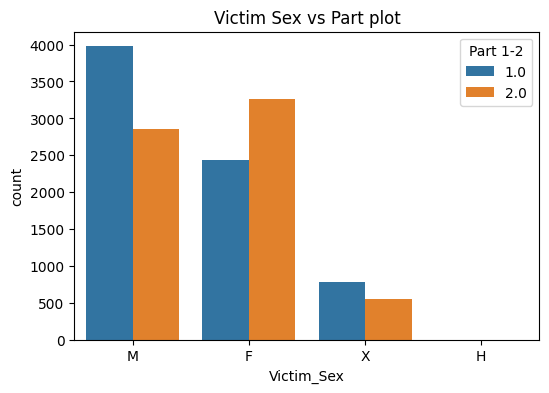

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x = 'Victim_Sex', hue = 'Part 1-2', data = x_train)
plt.title('Victim Sex vs Part plot')
plt.show()

Proportion of part 1 cases over part 2 is more in sex gropus - Male and X 
where as in female more cases come under part 2.
We can also have an understanding of total case count per sex using the same plot

**Reporting_District_no vs Part plot**

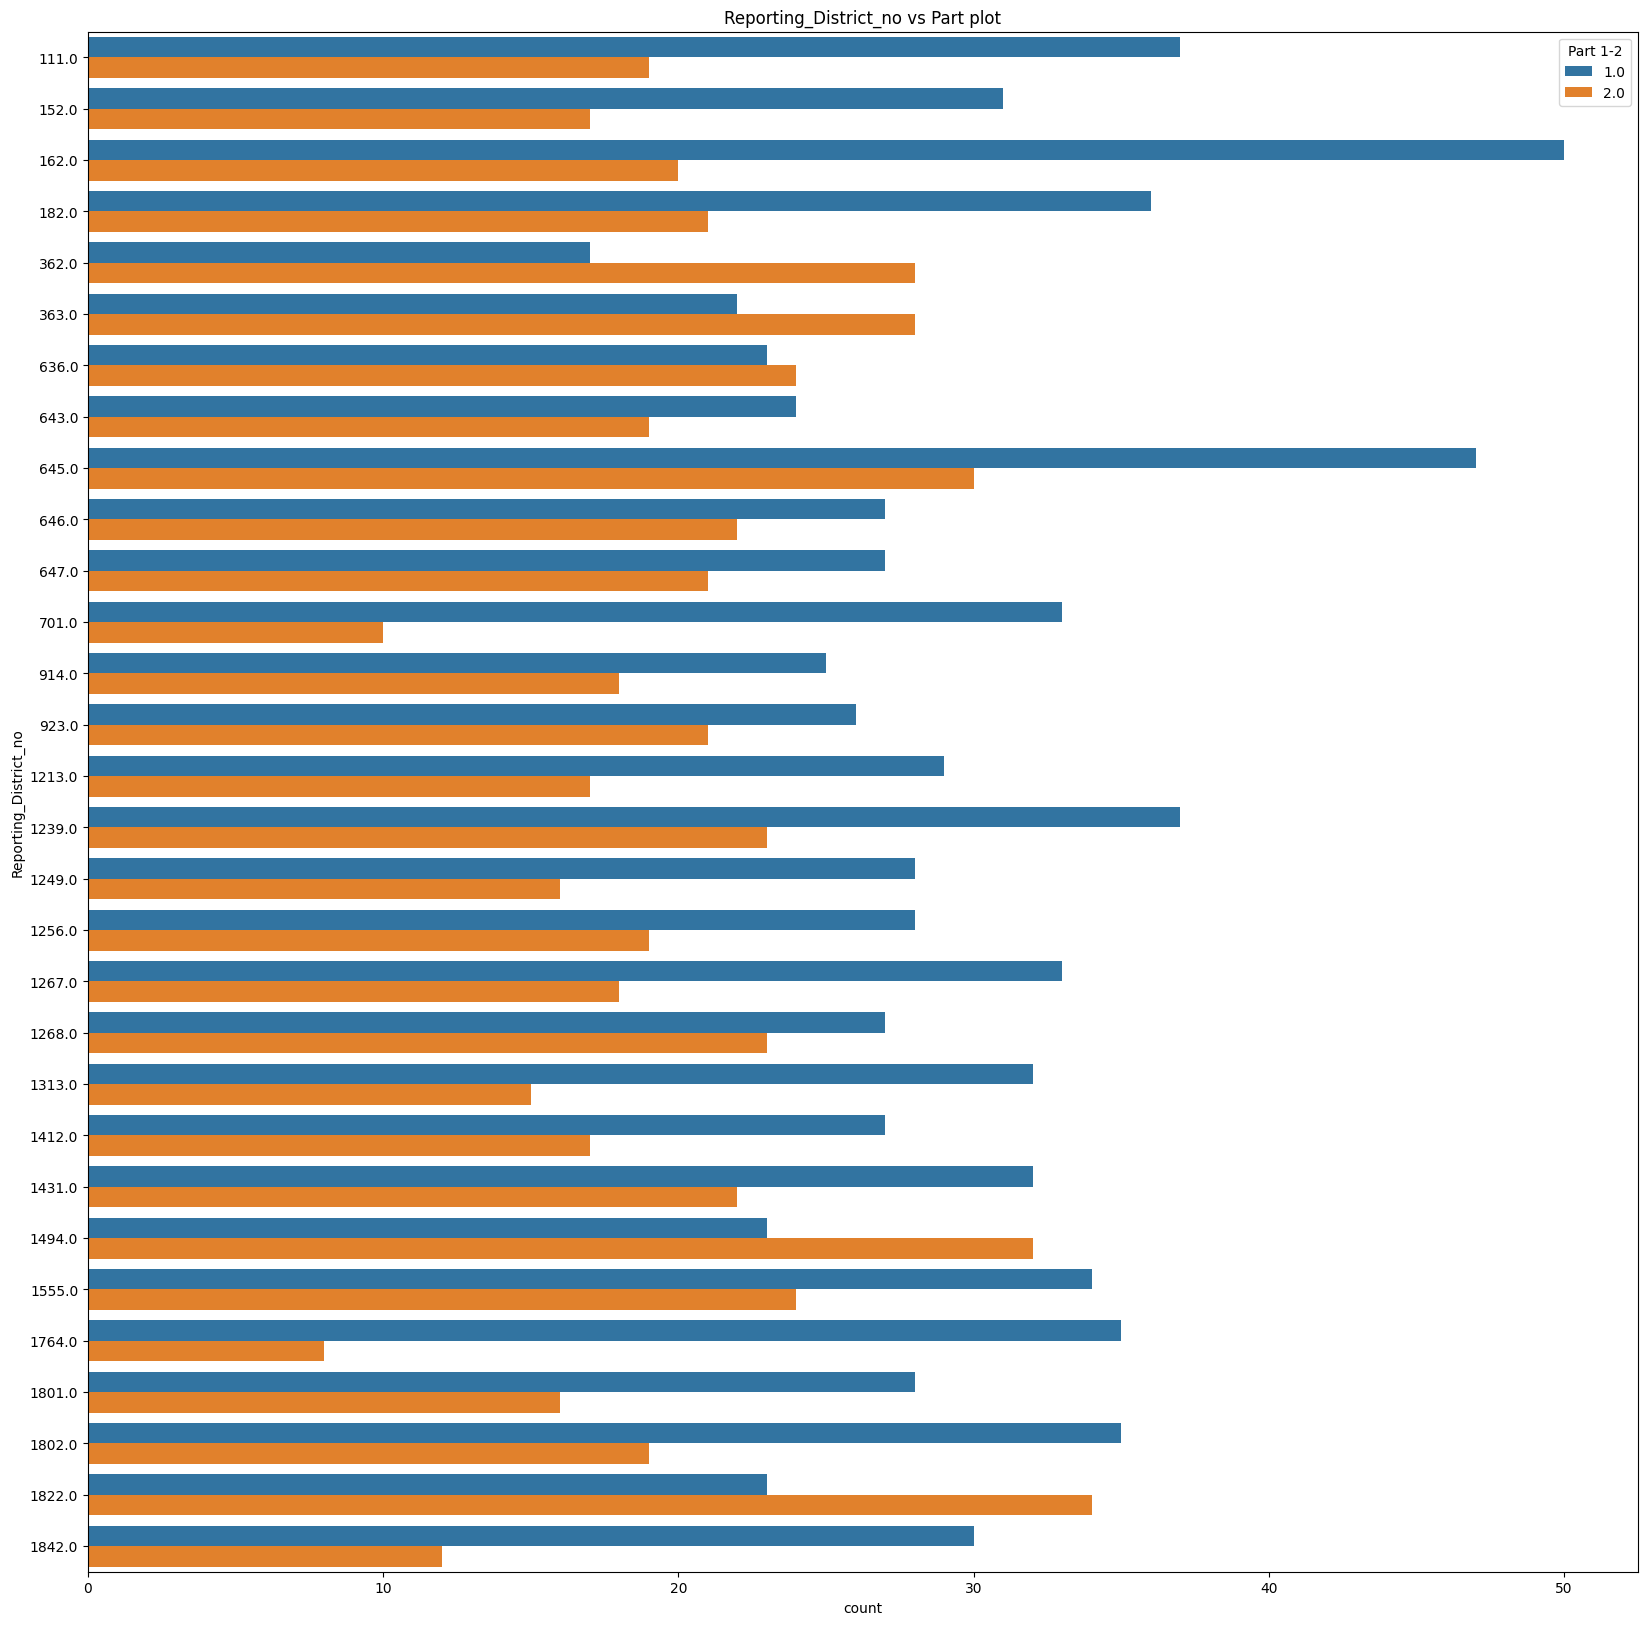

In [33]:
plt.figure(figsize=(20,20))
top20_by_dist = x_train['Reporting_District_no'].value_counts().head(30).index.tolist()
sns.countplot(y = 'Reporting_District_no', hue = 'Part 1-2', data = x_train[x_train['Reporting_District_no'].isin(top20_by_dist)])
plt.title('Reporting_District_no vs Part plot')
plt.show()

**Victim_Descent vs Status**

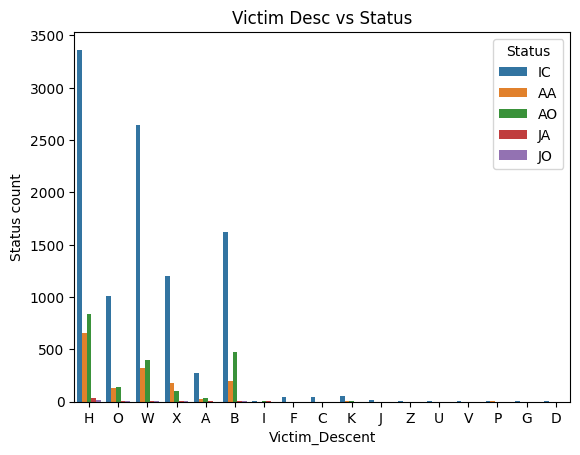

In [34]:
sns.countplot(x='Victim_Descent', data=x_train, hue='Status')
plt.title('Victim Desc vs Status')
plt.xlabel('Victim_Descent')
plt.ylabel('Status count')
plt.show()

The distrebution on status counts among different descend groups also seems to be proportional to the total crimes under each descent groups

**Victim_Age vs Gender**

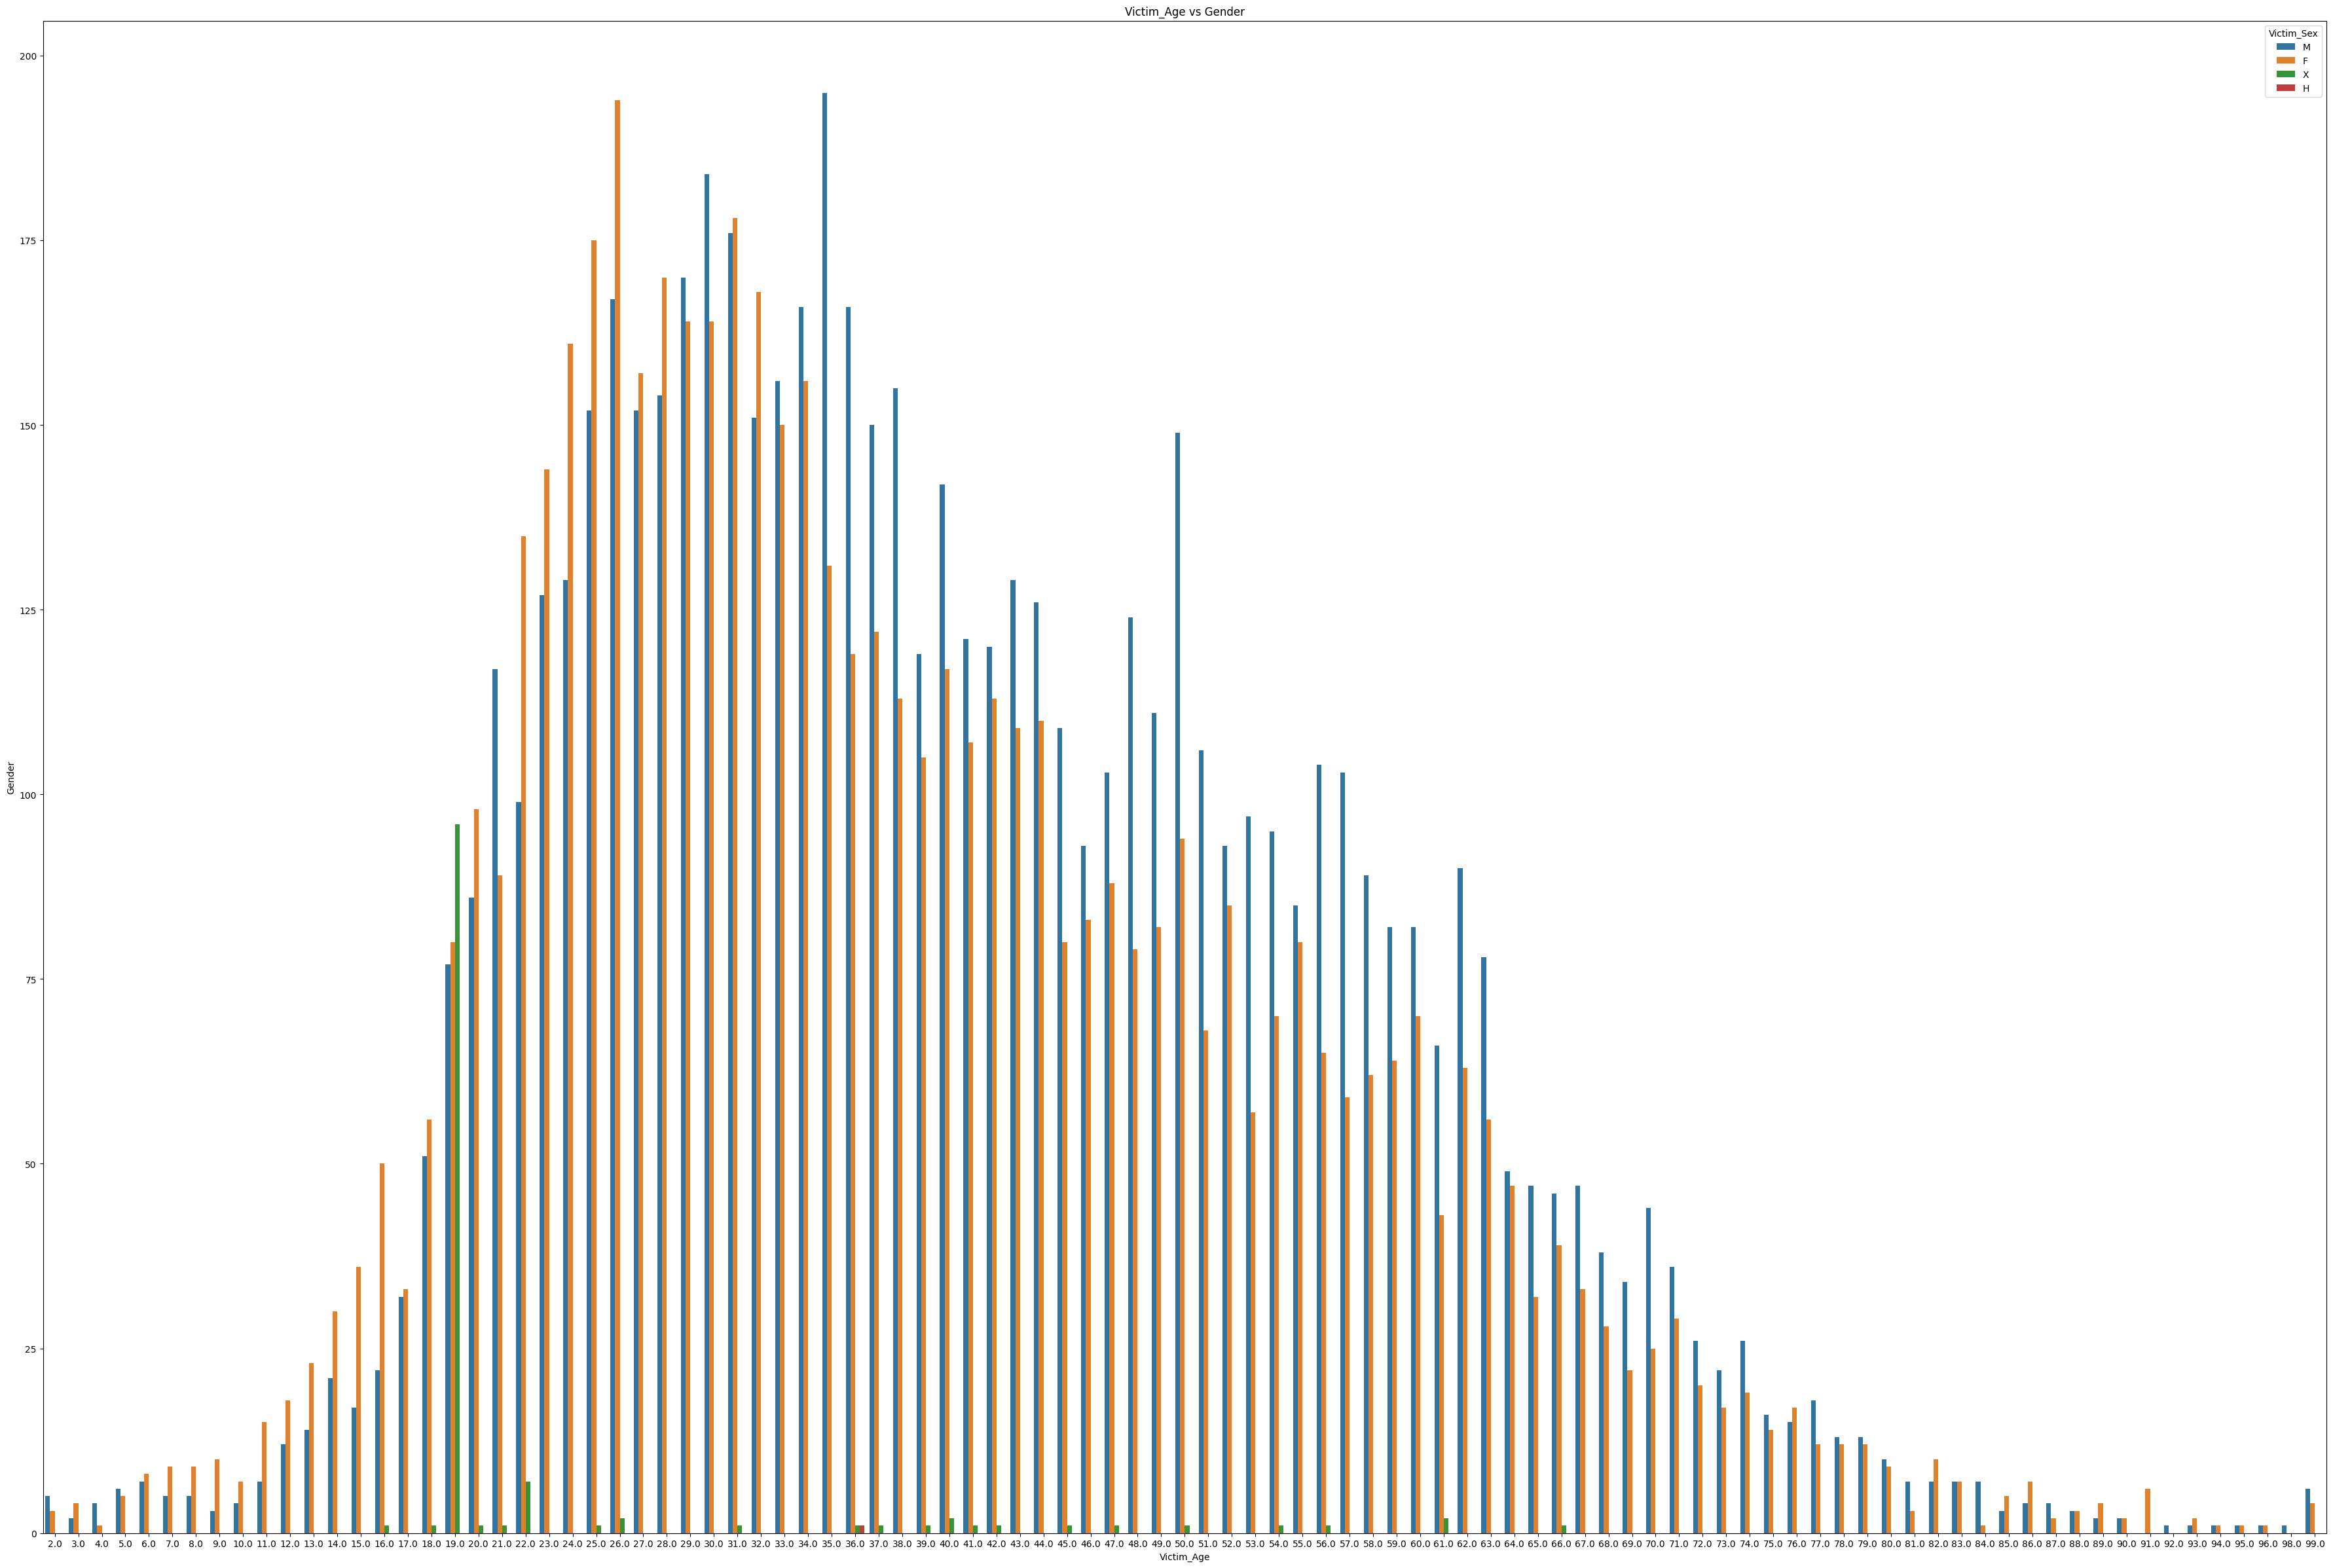

In [35]:
invalid_age_trimmed_rows = x_train[(x_train['Victim_Age'] > 0)]
plt.figure(figsize=(45, 30))
sns.countplot(x='Victim_Age', data=invalid_age_trimmed_rows, hue='Victim_Sex')
plt.title('Victim_Age vs Gender')
plt.xlabel('Victim_Age')
plt.ylabel('Gender')
plt.show()

In the age group below 35 - it is the female's that is being victimized, this could be indicative of the increased sexual / domestic violence.
However we need more exploration and domain knowledge for conclusion.

# Preprocessing pipeline

In [36]:
poly = PolynomialFeatures(degree = 2, interaction_only = True)
categoric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ('poly', poly)
])
categoric_columns = ['Area_ID', 'Reporting_District_no', 'Victim_Sex',
                     'Victim_Descent','Premise_Code','Status']

pre_processing = ColumnTransformer(
    transformers=[
        ('age_pipeline', age_pipeline, ['Victim_Age']),
        ('military_time_pipeline', military_time_pipeline, ['Time_Occurred']),
        ('part_pipeline', part_pipeline, ['Part 1-2']),
        ('date_delay_pipeline', date_delay_pipeline, ['Date_Occurred', 'Date_Reported']),
        ('textTransformer', textTransformer, ['Modus_Operandi']), 
        ('categoric_pipeline', categoric_pipeline, categoric_columns)
    ]
)

# **Feature Selection**

Let's retain feature count = 10% of the total training samples for now - ie 2000

In [37]:
selector = SelectKBest(score_func = f_classif, k=2000)
selected_features_pipeline = Pipeline(steps=[
    ('pre_processing',pre_processing),
    ('feature_selector', selector)
])
processed_pipeline = selected_features_pipeline

# Utils

In [38]:
def show_confusion_matrix(y, y_pred, classifier):
    con_mat_lr = confusion_matrix(y,y_pred)
    con_display_lr = ConfusionMatrixDisplay(con_mat_lr)
    con_display_lr.plot()
    
    plt.title("Confusion Matrix for {classifier}".format(classifier = classifier))
    plt.show()
    
def plot_learning_curve(model, x, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, x, y, cv=5, n_jobs=-1,verbose=-1
    )
    
    train_scores = pd.DataFrame(train_scores).fillna(train_scores[~np.isnan(train_scores)].mean()).to_numpy()
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_scores = pd.DataFrame(test_scores).fillna(test_scores[~np.isnan(test_scores)].mean()).to_numpy()
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
    plt.xlabel('Training set size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.show()
    
def fit_model_and_get_time_taken(model):
    start = time.time()
    model.fit(x_train, y_train)
    end = time.time()
    return end - start
    
    

# Baseline - DummyClassifier

In [39]:
# dummy_classifier = DummyClassifier()
# dummy_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
#                       ('classifier', dummy_classifier)])
# dummy_pipeline.fit(x_train, y_train)

In [40]:
# y_train_pred = dummy_pipeline.predict(x_train)
# print(classification_report(y_train, y_train_pred))

In [41]:
# y_validation_pred = dummy_pipeline.predict(x_validation)
# print(classification_report(y_validation, y_validation_pred))

In [42]:
# show_confusion_matrix(y_validation, y_validation_pred, "Dummy")

# RandomForestClassifier

In [43]:
rf_classifier = RandomForestClassifier()

rf_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
                      ('classifier_model', rf_classifier)])
rf_time = fit_model_and_get_time_taken(rf_pipeline)
rf_pipeline

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('processed_pipeline',
                 Pipeline(steps=[('pre_processing',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('invalid_age_transformer',
                                                                                    FunctionTransformer(func=<function replace_zero_or_negative at 0x78b1c5f13a30>,
                                                                                                        validate=True)),
                                                                                   ('smpl_imputer',
                                                                                    SimpleImputer()),
                                                                                   ('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Victim_Age']),
                                                                  ('military...
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('poly',
                                                                                    PolynomialFeatures(interaction_only=True))]),
                                                                   ['Area_ID',
                                                                    'Reporting_District_no',
                                                                    'Victim_Sex',
                                                                    'Victim_Descent',
                                                                    'Premise_Code',
                                                                    'Status'])])),
                                 ('feature_selector', SelectKBest(k=2000))])),
                ('classifier_model', RandomForestClassifier())])

In [44]:
y_train_pred = rf_pipeline.predict(x_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       193
           1       1.00      1.00      1.00      1434
           2       1.00      1.00      1.00      1088
           3       1.00      1.00      1.00       144
           4       1.00      1.00      1.00      9363
           5       1.00      1.00      1.00      3778

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000



In [45]:
y_validation_pred = rf_pipeline.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           0       0.62      0.16      0.25        32
           1       0.87      0.66      0.75       374
           2       0.91      0.88      0.90       267
           3       1.00      0.06      0.11        35
           4       0.96      0.98      0.97      2303
           5       0.86      0.96      0.90       989

    accuracy                           0.92      4000
   macro avg       0.87      0.62      0.65      4000
weighted avg       0.92      0.92      0.92      4000



In [46]:
rf_accuracy = accuracy_score(y_validation, y_validation_pred)
rf_accuracy

0.92275

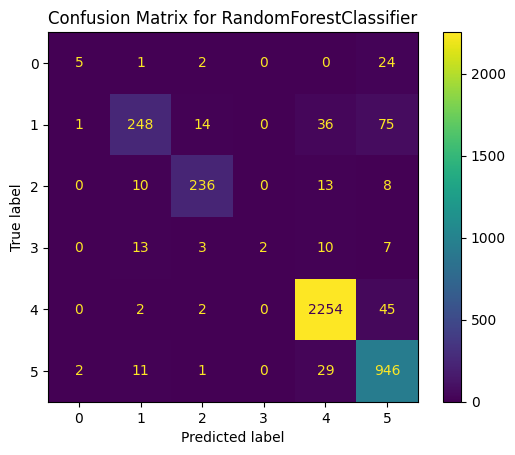

In [47]:
show_confusion_matrix(y_validation, y_validation_pred, "RandomForestClassifier")

# KNeighborsClassifier

In [48]:
kneighbors_classifier = KNeighborsClassifier(10)

kneighbours_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
                      ('classifier_model', kneighbors_classifier)])

knn_time = fit_model_and_get_time_taken(kneighbours_pipeline)
kneighbours_pipeline

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('processed_pipeline',
                 Pipeline(steps=[('pre_processing',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('invalid_age_transformer',
                                                                                    FunctionTransformer(func=<function replace_zero_or_negative at 0x78b1c5f13a30>,
                                                                                                        validate=True)),
                                                                                   ('smpl_imputer',
                                                                                    SimpleImputer()),
                                                                                   ('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Victim_Age']),
                                                                  ('military...
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('poly',
                                                                                    PolynomialFeatures(interaction_only=True))]),
                                                                   ['Area_ID',
                                                                    'Reporting_District_no',
                                                                    'Victim_Sex',
                                                                    'Victim_Descent',
                                                                    'Premise_Code',
                                                                    'Status'])])),
                                 ('feature_selector', SelectKBest(k=2000))])),
                ('classifier_model', KNeighborsClassifier(n_neighbors=10))])

In [49]:
y_train_pred = kneighbours_pipeline.predict(x_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       193
           1       0.60      0.22      0.32      1434
           2       0.72      0.52      0.60      1088
           3       0.00      0.00      0.00       144
           4       0.80      0.95      0.86      9363
           5       0.67      0.63      0.65      3778

    accuracy                           0.76     16000
   macro avg       0.63      0.39      0.41     16000
weighted avg       0.74      0.76      0.73     16000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
y_validation_pred = kneighbours_pipeline.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.40      0.11      0.18       374
           2       0.55      0.33      0.42       267
           3       0.00      0.00      0.00        35
           4       0.76      0.92      0.83      2303
           5       0.62      0.60      0.61       989

    accuracy                           0.71      4000
   macro avg       0.39      0.33      0.34      4000
weighted avg       0.67      0.71      0.67      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
knn_accuracy = accuracy_score(y_validation, y_validation_pred)
knn_accuracy

0.71025

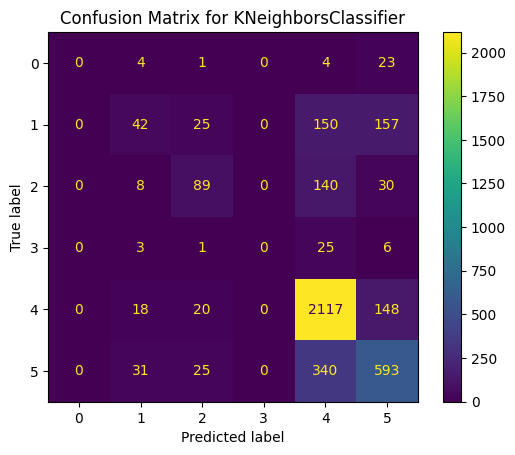

In [52]:
show_confusion_matrix(y_validation, y_validation_pred, "KNeighborsClassifier")

# SVC

In [53]:
svc = SVC(C=2, degree=2)
svc_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
                      ('classifier_model', svc)])

svc_time = fit_model_and_get_time_taken(svc_pipeline)
svc_pipeline

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('processed_pipeline',
                 Pipeline(steps=[('pre_processing',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('invalid_age_transformer',
                                                                                    FunctionTransformer(func=<function replace_zero_or_negative at 0x78b1c5f13a30>,
                                                                                                        validate=True)),
                                                                                   ('smpl_imputer',
                                                                                    SimpleImputer()),
                                                                                   ('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Victim_Age']),
                                                                  ('military...
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('poly',
                                                                                    PolynomialFeatures(interaction_only=True))]),
                                                                   ['Area_ID',
                                                                    'Reporting_District_no',
                                                                    'Victim_Sex',
                                                                    'Victim_Descent',
                                                                    'Premise_Code',
                                                                    'Status'])])),
                                 ('feature_selector', SelectKBest(k=2000))])),
                ('classifier_model', SVC(C=2, degree=2))])

In [54]:
y_train_pred = svc_pipeline.predict(x_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97       193
           1       0.96      0.94      0.95      1434
           2       0.99      0.98      0.99      1088
           3       1.00      0.88      0.93       144
           4       0.99      0.99      0.99      9363
           5       0.97      0.98      0.98      3778

    accuracy                           0.98     16000
   macro avg       0.98      0.95      0.97     16000
weighted avg       0.98      0.98      0.98     16000



In [55]:
y_validation_pred = svc_pipeline.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           0       0.33      0.06      0.11        32
           1       0.77      0.77      0.77       374
           2       0.93      0.91      0.92       267
           3       0.50      0.06      0.10        35
           4       0.98      0.98      0.98      2303
           5       0.87      0.93      0.90       989

    accuracy                           0.92      4000
   macro avg       0.73      0.62      0.63      4000
weighted avg       0.92      0.92      0.92      4000



In [56]:
svc_accuracy = accuracy_score(y_validation, y_validation_pred)
svc_accuracy

0.9245

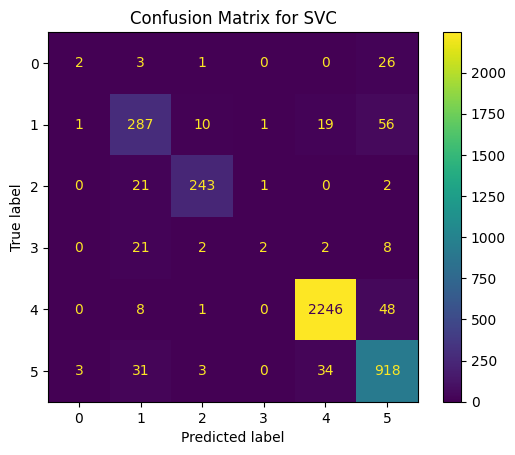

In [57]:
show_confusion_matrix(y_validation, y_validation_pred, "SVC")

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_fea

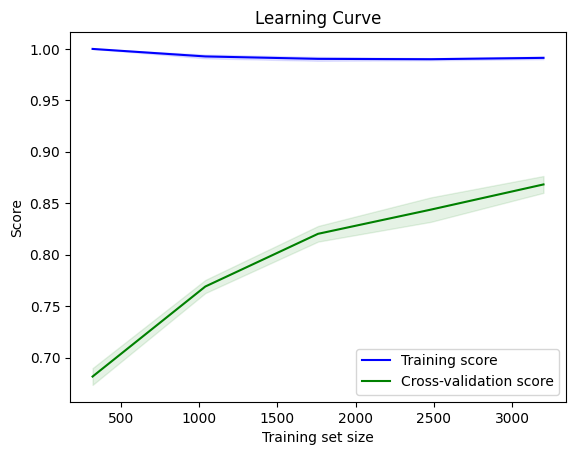

In [58]:
plot_learning_curve(svc_pipeline, x_validation, y_validation)

- **HPT**

# LGBMClassifier

In [59]:
lgbm = LGBMClassifier(colsample_bytree = 0.8, min_child_samples= 10, reg_lambda= 0.17,  verbose = -1)

lgbm_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
                      ('classifier_model', lgbm)])

lgbm_time = fit_model_and_get_time_taken(lgbm_pipeline)
lgbm_pipeline

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('processed_pipeline',
                 Pipeline(steps=[('pre_processing',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('invalid_age_transformer',
                                                                                    FunctionTransformer(func=<function replace_zero_or_negative at 0x78b1c5f13a30>,
                                                                                                        validate=True)),
                                                                                   ('smpl_imputer',
                                                                                    SimpleImputer()),
                                                                                   ('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Victim_Age']),
                                                                  ('military...
                                                                                   ('onehot_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('poly',
                                                                                    PolynomialFeatures(interaction_only=True))]),
                                                                   ['Area_ID',
                                                                    'Reporting_District_no',
                                                                    'Victim_Sex',
                                                                    'Victim_Descent',
                                                                    'Premise_Code',
                                                                    'Status'])])),
                                 ('feature_selector', SelectKBest(k=2000))])),
                ('classifier_model',
                 LGBMClassifier(colsample_bytree=0.8, min_child_samples=10,
                                reg_lambda=0.17, verbose=-1))])

In [60]:
y_train_pred = lgbm_pipeline.predict(x_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       193
           1       1.00      1.00      1.00      1434
           2       1.00      1.00      1.00      1088
           3       1.00      1.00      1.00       144
           4       1.00      1.00      1.00      9363
           5       1.00      1.00      1.00      3778

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000



In [61]:
y_validation_pred = lgbm_pipeline.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76        32
           1       0.82      0.86      0.84       374
           2       0.96      0.93      0.95       267
           3       0.33      0.11      0.17        35
           4       0.99      0.99      0.99      2303
           5       0.94      0.95      0.94       989

    accuracy                           0.95      4000
   macro avg       0.80      0.77      0.77      4000
weighted avg       0.95      0.95      0.95      4000



In [62]:
lgbm_accuracy = accuracy_score(y_validation, y_validation_pred)
lgbm_accuracy

0.953

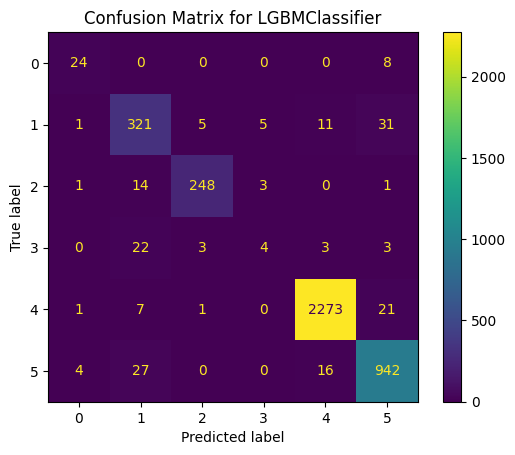

In [63]:
show_confusion_matrix(y_validation, y_validation_pred, "LGBMClassifier")

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_fea

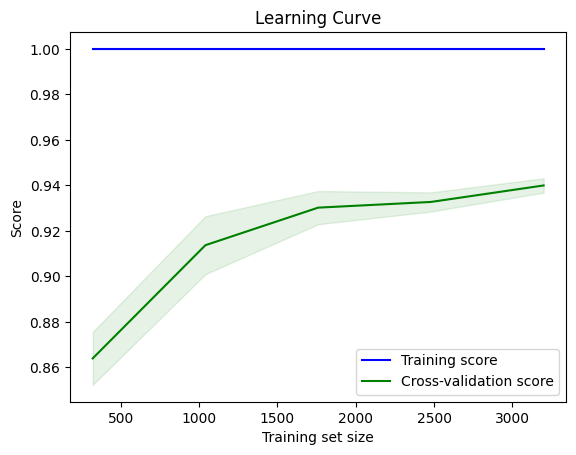

In [64]:
plot_learning_curve(lgbm_pipeline, x_validation, y_validation)

**Validation Curve**

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[0.9997125 0.99975   0.9997125 0.9997    0.9996625 0.999625  0.99965
 0.9996375 0.99965   0.99965  ]
[0.95375 0.95405 0.9535  0.9537  0.9541  0.9533  0.953   0.9538  0.953
 0.95325]


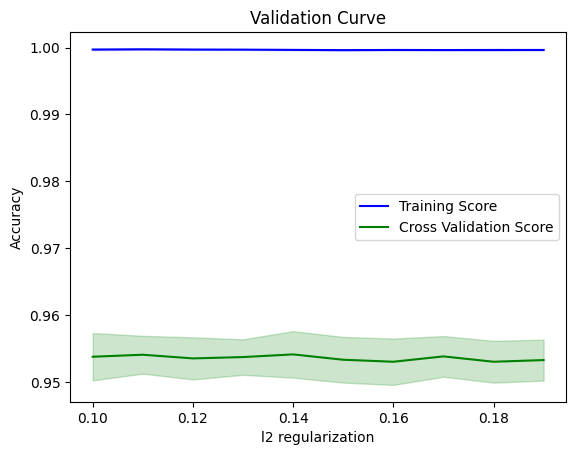

In [65]:
m = LGBMClassifier(colsample_bytree = 0.8, min_child_samples= 10,  verbose = -1)
param_range=np.arange(0.1, 0.2, 0.01)
x_full_transformed = processed_pipeline.fit_transform(X, label_encoded_y)
train_scores, test_scores =  validation_curve(m, x_full_transformed, label_encoded_y, param_name="reg_lambda", param_range=param_range, cv = 5)

mean_train_score = np.mean(train_scores, axis=1)
std_train_score = np.std(train_scores, axis=1)
mean_test_score = np.mean(test_scores, axis=1)
std_test_score = np.std(test_scores, axis=1)
print(mean_train_score)
print(mean_test_score)

plt.plot(param_range, mean_train_score, label="Training Score", color='b')
plt.plot(param_range, mean_test_score, label="Cross Validation Score", color='g')

plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='blue')
plt.fill_between(param_range, mean_test_score - std_test_score, mean_test_score + std_test_score, alpha=0.2, color='green')

plt.title("Validation Curve")
plt.xlabel("l2 regularization")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# XGBClassifier

In [66]:
xgb = XGBClassifier(subsample = 0.8, reg_lambda = 1.2, max_depth=18, gamma = 1, eta = 0.2, colsample_bytree=0.7)

xgb_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
                      ('classifier_model', xgb)])

xgb_time = fit_model_and_get_time_taken(xgb_pipeline)
xgb_pipeline

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('processed_pipeline',
                 Pipeline(steps=[('pre_processing',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('invalid_age_transformer',
                                                                                    FunctionTransformer(func=<function replace_zero_or_negative at 0x78b1c5f13a30>,
                                                                                                        validate=True)),
                                                                                   ('smpl_imputer',
                                                                                    SimpleImputer()),
                                                                                   ('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Victim_Age']),
                                                                  ('military...
                               eval_metric=None, feature_types=None, gamma=1,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=18, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [67]:
y_train_pred = xgb_pipeline.predict(x_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       193
           1       0.94      0.96      0.95      1434
           2       0.99      0.98      0.98      1088
           3       0.94      0.68      0.79       144
           4       1.00      1.00      1.00      9363
           5       0.98      0.99      0.98      3778

    accuracy                           0.99     16000
   macro avg       0.96      0.92      0.94     16000
weighted avg       0.99      0.99      0.99     16000



In [68]:
y_valid_pred = xgb_pipeline.predict(x_validation)
print(classification_report(y_validation, y_valid_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.65        32
           1       0.82      0.84      0.83       374
           2       0.95      0.93      0.94       267
           3       0.54      0.20      0.29        35
           4       0.99      0.99      0.99      2303
           5       0.93      0.95      0.94       989

    accuracy                           0.95      4000
   macro avg       0.82      0.76      0.77      4000
weighted avg       0.95      0.95      0.95      4000



In [69]:
xgb_accuracy = accuracy_score(y_validation, y_valid_pred)
xgb_accuracy

0.95

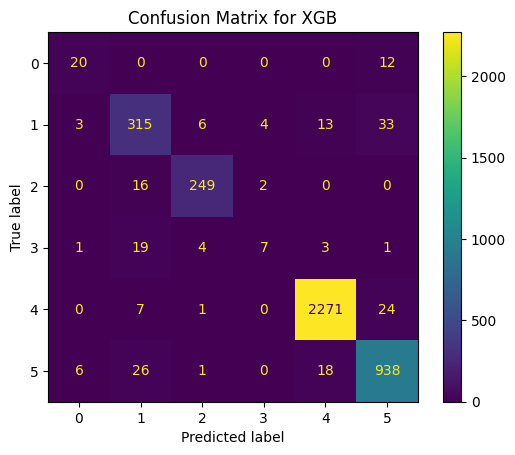

In [70]:
show_confusion_matrix(y_validation, y_valid_pred, "XGB")

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_fea

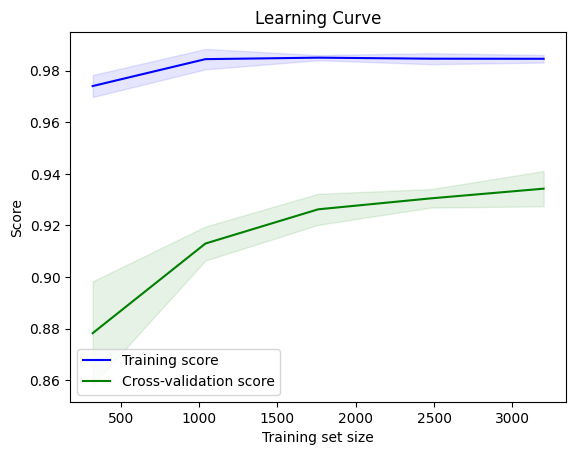

In [71]:
plot_learning_curve(xgb_pipeline, x_validation, y_validation)

# MLPClassifier

In [72]:
# mlp = MLPClassifier()

# mlp_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
#                        ('classifier_model', mlp)])

# mlp_pipeline.fit(x_train, y_train)

In [73]:
# y_train_pred = mlp_pipeline.predict(x_train)
# print(classification_report(y_train, y_train_pred))

In [74]:
# y_valid_pred = mlp_pipeline.predict(x_validation)
# print(classification_report(y_validation, y_valid_pred))

In [75]:
# show_confusion_matrix(y_validation, y_valid_pred, "MLP")

In [76]:
# plot_learning_curve(mlp_pipeline, x_validation, y_validation)

# BaggingClassifier

In [77]:
# base_clf = DecisionTreeClassifier()
# bagging = BaggingClassifier(estimator=base_clf, n_estimators=100, random_state=0)

# bagging_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
#                         ('classifier_model', bagging)])

# bagging_pipeline.fit(x_train, y_train)

In [78]:
# y_train_pred = bagging_pipeline.predict(x_train)
# print(classification_report(y_train, y_train_pred))

In [79]:
# y_valid_pred = bagging_pipeline.predict(x_validation)
# print(classification_report(y_validation, y_valid_pred))

In [80]:
# accuracy_score(y_validation, y_valid_pred)

In [81]:
# show_confusion_matrix(y_validation, y_valid_pred, "BaggingClassifier")

In [82]:
# plot_learning_curve(bagging_pipeline, x_validation, y_validation)

# Score vs Time taken plot for Classifiers

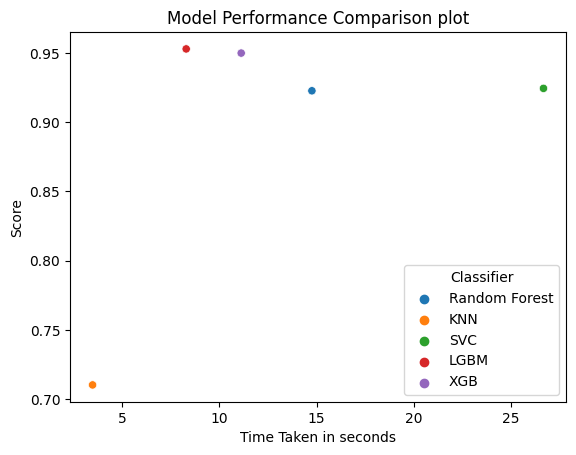

In [83]:
data = {'model_name': ['Random Forest', 'KNN', 'SVC', 'LGBM', 'XGB'],
        'time_taken': [rf_time, knn_time, svc_time, lgbm_time, xgb_time],
        'score': [rf_accuracy, knn_accuracy, svc_accuracy, lgbm_accuracy, xgb_accuracy]}
df = pd.DataFrame(data)

sns.scatterplot(x='time_taken', y='score', hue='model_name', data=df)
plt.xlabel('Time Taken in seconds')
plt.ylabel('Score')
plt.legend(title='Classifier')
plt.title('Model Performance Comparison plot')
plt.show()

# **HPT**

In [84]:
# X_processed = processed_pipeline.fit_transform(x_train, y_train)

- **RandomForestClassifier**

In [85]:
# param_grid = {
#     'n_estimators': [10, 100, 150], 
#     'max_features': ['auto', 'sqrt'],
#     'max_depth':[None, 10, 20, 50, 100, 150],
#     'min_samples_split': [1, 2, 5, 10], 
#     'min_samples_leaf' : [1, 3, 4],
#     'bootstrap': [True, False]
# }

# grid = RandomizedSearchCV(RandomForestClassifier() , param_grid ,cv=3, refit=True , verbose=3, n_jobs=-1, n_iter=100)
# grid.fit(X_processed,y_train)

- **KNeighborsClassifier**

In [86]:
# param_grid = {
#     'n_neighbors': [7,10], 
#     'weights': ['uniform', 'distance'],
#     'p':[1,2,3]
# }

# grid = RandomizedSearchCV(KNeighborsClassifier() , param_grid ,cv=3, refit=True , verbose=3, n_jobs=-1, n_iter=100)
# grid.fit(X_processed,y_train)

- **SVC**

In [87]:
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
#     'C':[0.1, 0.5, 0.6, 1, 1.5],
#     'gamma': ['scale','auto', 0.1, 0.01, 0.005 ,0.001, 0.0001], 
#     'degree' : [1,2,3,4,5]
# }

# grid = RandomizedSearchCV(SVC() , param_grid ,cv=3, refit=True , verbose=3, n_jobs=-1, n_iter=100)
# grid.fit(X_processed,y_train)

HPT evaluation:
- Default params score: 0.9315
- param_grid = {
     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
     'C':[0.1, 0.5, 0.6, 1, 1.5],
     'gamma': ['scale','auto', 0.1, 0.01, 0.005 ,0.001, 0.0001], 
     'degree' : [1,2,3,4,5]
   }
 - best_params_ : {'kernel': 'linear', 'gamma': 0.01, 'degree': 3, 'C': 0.5}
 - best_score_: 0.9378749604546197
 

- **LGBMClassifier**

In [88]:
# param_grid = {
# "colsample_bytree": [0.8],
# "min_child_samples":[10],
# "reg_alpha": [0,0.001, 0.01, 0.1],
# "reg_lambda": [0,0.001, 0.01, 0.1]
# }

# grid = GridSearchCV(LGBMClassifier(), param_grid ,cv=3, refit=True , n_jobs=-1)
# grid.fit(X_processed,y_train)

HPT evaluation: 
- Random:
initial - did not record params - near to next one
{'subsample': 1.0, 'num_leaves': 127, 'max_depth': 8, 'colsample_bytree': 0.8}
best score: 0.9528749605718

- param_grid = {
"num_leaves": [63, 127, 190, 255, 511, 1023],
"max_depth": [6, 7, 8 , 9, 10, 11, 12],
"subsample": [0.5, 0.8, 1.0, 1.2, 1.5],
"colsample_bytree": [0.5, 0.8, 1.0, 1.2, 1.5]
}
- best params: {'subsample': 0.5, 'num_leaves': 255, 'max_depth': 12, 'colsample_bytree': 0.5}
- best score: 0.9536249722

- Grid:
param_grid = {
"num_leaves": [63, 127, 255, 511],
"max_depth": [8 , 12, 15, 18],
"subsample": [0.5, 0.8, 1.0, 1.2, 1.5],
"colsample_bytree": [0.5, 0.8, 1.0]
}

- params: {'colsample_bytree': 0.5, 'max_depth': 12, 'num_leaves': 255, 'subsample': 0.5}
- best score: 0.9536249722956768

- param_grid = {
"colsample_bytree": [0.8],
"min_child_samples":[10],
"reg_alpha": [0,0.001, 0.01, 0.1],
"reg_lambda": [0,0.001, 0.01, 0.1]
}

- params {'colsample_bytree': 0.8,
 'min_child_samples': 10,
 'reg_alpha': 0,
 'reg_lambda': 0.1}
 
 - 0.9526876129045654

- **XGBClassifier**

In [89]:
# param_grid ={
#     'eta' : np.arange(0,1.2,0.2),
#     'gamma': np.arange(0, 11, 1),
#     'max_depth': np.arange(3, 19, 3),
#     'min_child_weight' : np.arange(0, 11, 1),
#     'max_delta_step': np.arange(0, 12, 2),
#     'subsample': np.arange(0,1.2,0.2),
#     'colsample_bytree' : np.arange(0.5,1.1, 0.1),
#     'reg_alpha' : np.arange(0,11,1),
#     'reg_lambda' : np.arange(0,2, 0.1)
# }



# grid = RandomizedSearchCV(XGBClassifier() , param_grid ,cv=3, refit=True , verbose=3, n_jobs=-1, n_iter=500)
# grid.fit(X_processed,y_train)

HPT evaluation:

- default score: 0.9475
- Random: param_grid ={
    'eta' : np.arange(0,1.2,0.2),
    'gamma': np.arange(0, 11, 1),
    'max_depth': np.arange(3, 19, 3),
    'min_child_weight' : np.arange(0, 11, 1),
    'max_delta_step': np.arange(0, 12, 2),
    'subsample': np.arange(0,1.2,0.2),
    'colsample_bytree' : np.arange(0.5,1.1, 0.1),
    'reg_alpha' : np.arange(0,11,1),
    'reg_lambda' : np.arange(0,2, 0.1)
}

- best params:  {'subsample': 0.8,
 'reg_lambda': 1.2000000000000002,
 'reg_alpha': 0,
 'min_child_weight': 0,
 'max_depth': 18,
 'max_delta_step': 8,
 'gamma': 1,
 'eta': 0.2,
 'colsample_bytree': 0.7
 }
 
 - best score:0.9506251011704355

# Selected Model

In [90]:
classifier = LGBMClassifier(colsample_bytree = 0.8, min_child_samples= 10, reg_lambda= 0.17,  verbose = -1)
final_pipeline = Pipeline(steps=[('processed_pipeline', processed_pipeline),
                        ('classifier_model', classifier)])
final_pipeline.fit(X, label_encoded_y)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Pipeline(steps=[('processed_pipeline',
                 Pipeline(steps=[('pre_processing',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('invalid_age_transformer',
                                                                                    FunctionTransformer(func=<function replace_zero_or_negative at 0x78b1c5f13a30>,
                                                                                                        validate=True)),
                                                                                   ('smpl_imputer',
                                                                                    SimpleImputer()),
                                                                                   ('min_max_scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['Victim_Age']),
                                                                  ('military...
                                                                                   ('onehot_encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore')),
                                                                                   ('poly',
                                                                                    PolynomialFeatures(interaction_only=True))]),
                                                                   ['Area_ID',
                                                                    'Reporting_District_no',
                                                                    'Victim_Sex',
                                                                    'Victim_Descent',
                                                                    'Premise_Code',
                                                                    'Status'])])),
                                 ('feature_selector', SelectKBest(k=2000))])),
                ('classifier_model',
                 LGBMClassifier(colsample_bytree=0.8, min_child_samples=10,
                                reg_lambda=0.17, verbose=-1))])

# Load and predict on test data

In [91]:
x_test =  pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
x_test.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


In [92]:
y_test_pred = final_pipeline.predict(x_test)
y_test_pred = label_encoder.inverse_transform(y_test_pred)

# Submission

In [93]:
submission = pd.DataFrame(columns = ['ID', 'Crime_Category'])
submission['ID'] = [(i+1) for i in range(len(y_test_pred))]
submission['Crime_Category'] = y_test_pred
submission.to_csv('submission.csv', index = False)

In [94]:
s = pd.read_csv('/kaggle/working/submission.csv')
s.head()


,ID,Crime_Category
0,1,Violent Crimes
1,2,Property Crimes
2,3,Fraud and White-Collar Crimes
3,4,Property Crimes
4,5,Crimes against Public Order
